In [41]:
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches

In [42]:
class ApprenticeRegion:
    def __init__(self, csv_row, header):
        self.header = header
        coltypes = [int, str, str, str, str, str, int, float] + 114*[int] + [float, float]
        
        self.data = []
        for i in range(len(csv_row)):
            val_str = csv_row[i]
            f = coltypes[i]
            try:
                self.data.append(f(val_str))
            except ValueError:
                na = 0 if f == int else 0.0 
                self.data.append(na)
    
    def column_by_name(self, name):
        i = self.header.index(name)
        return self.data[i]
    
    def normalized_by_new(self, idx):
        j = self.header.index("Num_New_Reg")
        return self.data[idx]/self.data[j]

In [43]:
directory = "/Users/vic/Projects/open-toronto/raw_data/employment_ontario/"

with open(directory+"Apprenticeship_Program_Data_by_Local_Board_Area_FY1516.csv") as f:
    reader = csv.reader(f)
    lines = [row for row in reader]

header = lines[0]
app_regions = [ApprenticeRegion(row, header) for row in lines[1:]]

boards = [r.column_by_name("SDS_Name") for r in app_regions]

In [44]:
### Check the total number of apprentices with a known trade code (per region)
apps_start = 10
running_totals = len(app_regions)*[0]
for i in range(apps_start, len(header[:-2])):
    coldata = [r.data[i] for r in app_regions]    
    running_totals = [col+rt for col, rt in zip(coldata, running_totals)]
    
print("Total number of known-trade apprentices/new registrations/active registrations by region:")
print(running_totals)
print([r.column_by_name("Num_New_Reg") for r in app_regions])
print([r.column_by_name("Num_Active_Appr") for r in app_regions])

### Comment: The total number of apprentices registered in the listed trades does not correspond to either the
### number of new registrations or the number of active apprentices. There must be another trade not included
### in the listed ones. The difference can be quite big, e.g. the second board.

Total number of known-trade apprentices/new registrations/active registrations by region:
[1030, 1103, 301, 525, 247, 461, 919, 3097, 3150, 2214, 2110, 1122, 849, 436, 1534, 1113, 375, 775, 816, 170, 778, 287, 344, 222, 143, 161]
[1057, 1144, 344, 555, 290, 503, 961, 3151, 3195, 2277, 2169, 1181, 900, 477, 1599, 1189, 420, 853, 867, 214, 818, 325, 385, 271, 179, 196]
[2738, 4215, 1107, 1658, 893, 1521, 2850, 9237, 10703, 6663, 5267, 3928, 3161, 1647, 4790, 4018, 1609, 2276, 2127, 666, 2312, 943, 1285, 1089, 343, 960]


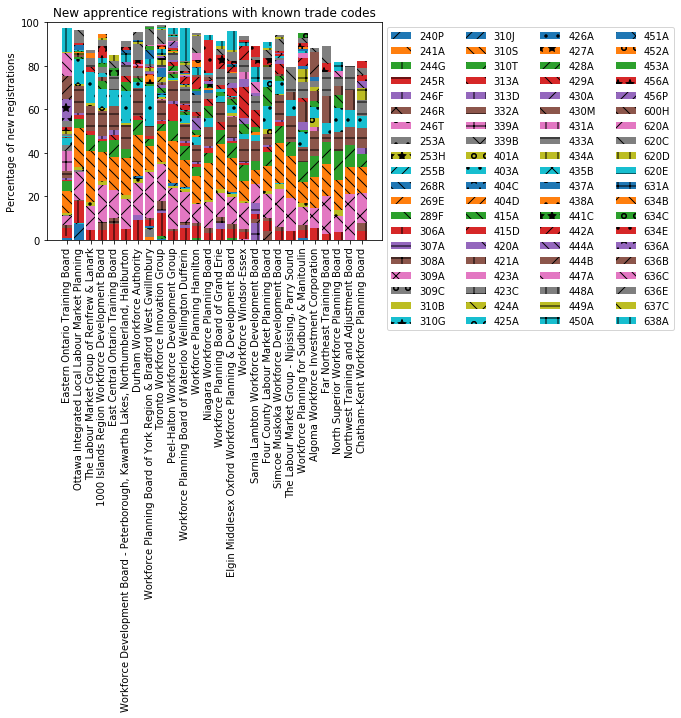

In [45]:
# Normalize New_Reg_XXXX by Num_New_Reg
fig, ax = plt.subplots()
x_loc = range(len(boards))
bottom = len(app_regions)*[0]
bars_for_legend = []
code_for_legend = []

patterns = [ "/", "\\", "|", "-", "+", "x", "o", ".", "*", "//", "\\\\"]
pt = 0

for i in range(apps_start, len(header[:-2])):
    coldata = [r.normalized_by_new(i) for r in app_regions]
    if sorted(coldata)[-1] == 0: # if there are no apprentices in any region
        continue
    #print(coldata)
    
    bar = ax.bar(x_loc, coldata, bottom=bottom, hatch=patterns[pt])
    bottom = [col+btm for col, btm in zip(coldata, bottom)]
    bars_for_legend.append(bar[0])
    code_for_legend.append(re.match(r'New_Reg_(\d\d\d\w)', header[i]).group(1))
    
    if pt < len(patterns)-1:
        pt += 1
    else: 
        pt = 0
    
ax.set_xticks(x_loc)
ax.set_xticklabels(boards, rotation=90)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
ax.set_ylabel("Percentage of new registrations")
    
plt.legend(tuple(bars_for_legend), tuple(code_for_legend), ncol=4, loc="upper left", bbox_to_anchor=(1,1))
plt.title("New apprentice registrations with known trade codes")
plt.show()

In [57]:
# Now look at NOC codes for layoffs versus NOC codes for trades
# Read in mapping of trade codes to NOC codes

with open(directory+"trades_nocs.csv") as f:
    reader = csv.reader(f)
    raw_trades = [row for row in reader]

trades_to_nocs = {}
for rt in raw_trades:
    trades_to_nocs["New_Reg_"+rt[1]] = rt[0] if rt[0] else "na"


# Convert trade data into NOC data
noc_totals = {}

for i in range(apps_start, len(header[:-2])):
    coldata = [r.data[i] for r in app_regions]
    noc = trades_to_nocs[header[i]] if header[i] in trades_to_nocs else "na"
    noc2 = noc[0:2] # take only the first two digits (to match layoff data)
    
    if noc2 in noc_totals:
        noc_totals[noc2] = [col+nt for col, nt in zip(coldata, noc_totals[noc2])]
    else:
        noc_totals[noc2] = coldata


# Convert 2 digit NOC codes to job areas
with open(directory+"noc_to_area.csv") as f:
    reader = csv.reader(f, delimiter="|")
    raw_nocs = [row for row in reader]

noc_to_area = {}
for rn in raw_nocs:
    noc_to_area[rn[0]] = rn[1]
noc_to_area["na"] = "Unknown" # Some trade codes have no NOC

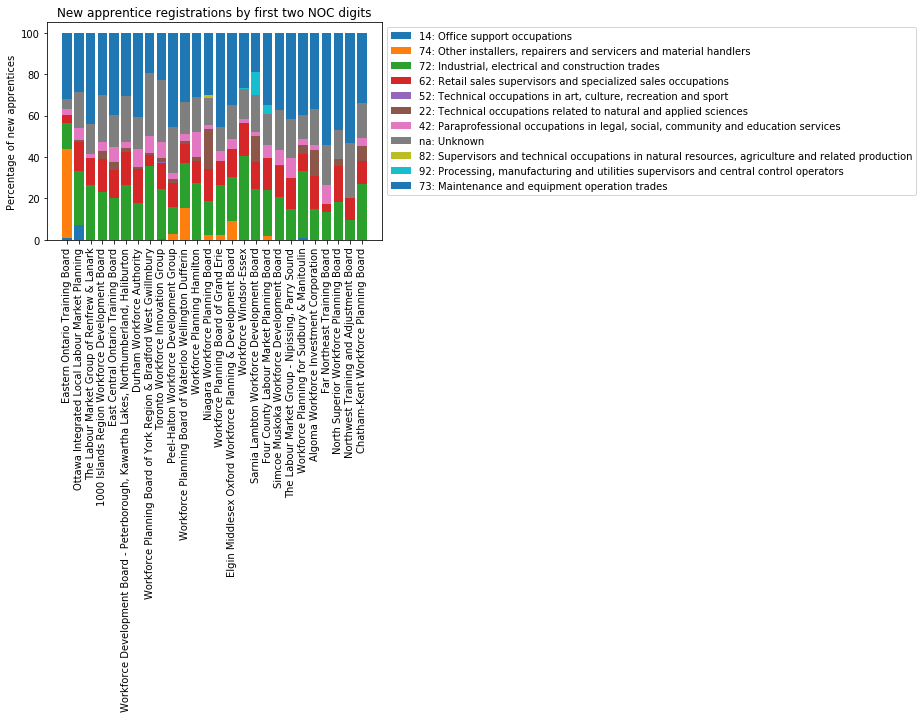

In [47]:
# Plot just apprentices by noc_totals

# Count up the total apprentices in each region for normalization
total_apprentices = len(app_regions)*[0]
for noc2 in noc_totals.keys():
    apps = noc_totals[noc2]
    total_apprentices = [a + ta for a, ta in zip(noc_totals[noc2], total_apprentices)]
    

fig, ax = plt.subplots()
bottom = len(app_regions)*[0]
bars_for_legend = []
noc2_for_legend = []

for noc2 in noc_totals.keys():
    coldata = [nt/ta for nt, ta in zip(noc_totals[noc2], total_apprentices)] # normalized, not raw
    if sorted(coldata)[-1] == 0: # if there are no apprentices in any region
        continue
    
    bar = ax.bar(x_loc, coldata, bottom=bottom)
    bottom = [col+btm for col, btm in zip(coldata, bottom)]
    bars_for_legend.append(bar[0])
    noc2_for_legend.append(noc2 + ": " + noc_to_area[noc2])
    
    ax.set_xticks(x_loc)
    ax.set_xticklabels(boards, rotation=90)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
    ax.set_ylabel("Percentage of new apprentices")
    
plt.legend(tuple(bars_for_legend), tuple(noc2_for_legend), loc="upper left", bbox_to_anchor=(1,1))
plt.title("New apprentice registrations by first two NOC digits")
plt.show()

In [48]:
# Now process the layoff data

class ServicesRegion:
    def __init__(self, csv_row, header):
        self.header = header
        coltypes = [int, str, str, str, str, str] + 112*[int] + [float, float]
        
        self.data = []
        for i in range(len(csv_row)):
            val_str = csv_row[i]
            f = coltypes[i]
            try:
                self.data.append(f(val_str))
            except ValueError:
                #print("Failed to convert", val_str, "to", str(f), "for", header[i])
                na = 0 if f == int else 0.0 # shouldn't fail to convert str to str, so only handle int and float
                self.data.append(na)
    
    def column_by_name(self, name):
        i = self.header.index(name)
        return self.data[i]

In [49]:
with open(directory+"Employment_Services_Program_Data_by_Local_Board_Area_FY1516.csv") as f:
    reader = csv.reader(f)
    lines = [row for row in reader]

services_header = lines[0]
serv_regions = [ServicesRegion(row, services_header) for row in lines[1:]]


layoff_start = services_header.index("Layoff_Occ_12")
layoff_end = services_header.index("Layoff_Occ_84")

In [50]:
# Check the consistency of the layoff data
layoff_totals = len(serv_regions)*[0]

for i in range(layoff_start, layoff_end+1):
    coldata = [r.data[i] for r in serv_regions]
    layoff_totals = [col+lt for col, lt in zip(coldata, layoff_totals)]
    
print("Total number of known-NOC layoffs/assisted people by region:")
print(layoff_totals)
print([r.column_by_name("Num_Assist") for r in serv_regions])

### Commentary: This time, there is a clear reason why the totals don't match. Some people being
# assisted will just have entered the labour market, and won't have been laid off from any occupation.

Total number of known-NOC layoffs/assisted people by region:
[3204, 5748, 2304, 2641, 1584, 1479, 3959, 5251, 19666, 8147, 4217, 1667, 4569, 1409, 6844, 3816, 775, 2103, 3311, 3077, 2104, 884, 1941, 795, 897, 1157]
[4823, 10786, 3770, 5605, 3442, 4767, 7979, 12679, 45417, 19188, 8668, 5014, 7054, 4267, 11805, 8104, 1825, 4190, 6353, 3500, 4260, 2384, 2842, 2441, 1537, 1688]


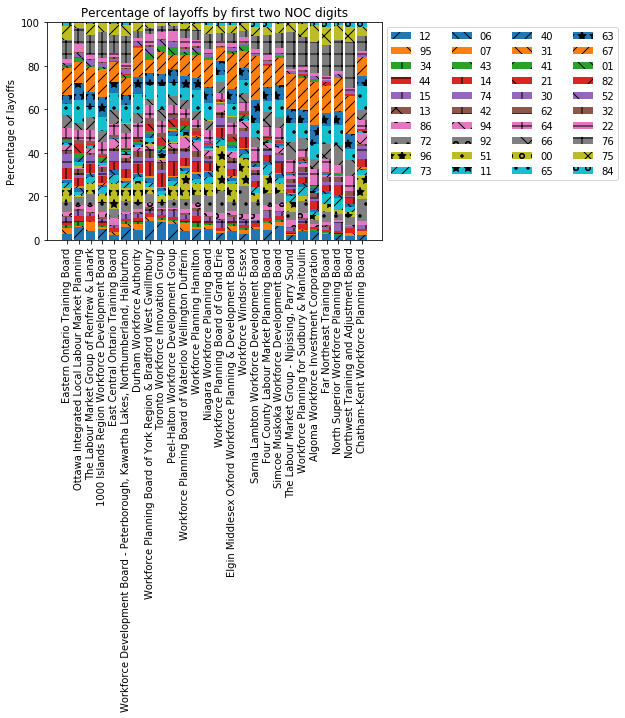

In [51]:
# Plot percentage of all layoffs by board 
fig, ax = plt.subplots()
bottom = len(serv_regions)*[0]
bars_for_legend = []
code_for_legend = []

pt = 0

for i in range(layoff_start, layoff_end+1):
    coldata = [serv_regions[j].data[i]/layoff_totals[j] for j in range(len(serv_regions))]
    if sorted(coldata)[-1] == 0: # if there are no layoffs in any region
        continue
    
    bar = ax.bar(x_loc, coldata, bottom=bottom, hatch=patterns[pt])
    bottom = [col+btm for col, btm in zip(coldata, bottom)]
    bars_for_legend.append(bar[0])
    code_for_legend.append(re.match(r'Layoff_Occ_(\d\d)', services_header[i]).group(1))
    
    if pt < len(patterns)-1:
        pt += 1
    else: 
        pt = 0
    
ax.set_xticks(x_loc)
ax.set_xticklabels(boards, rotation=90)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
ax.set_ylabel("Percentage of layoffs")
    
plt.legend(tuple(bars_for_legend), tuple(code_for_legend), ncol=4, loc="upper left", bbox_to_anchor=(1,1))
plt.title("Percentage of layoffs by first two NOC digits")
plt.show()

In [52]:
### Finally, prepare the data for a combined chart of layoffs and apprentices

# Sort nocs numerically, check for both layoffs and apprentices (some nocs missing from both lists)
lay_nocs = [re.match(r'Layoff_Occ_(\d\d)', services_header[i]).group(1) for i in range(layoff_start, layoff_end+1)]
app_nocs = list(noc_totals.keys())
ordered_nocs = sorted(list(set(lay_nocs+app_nocs)))


# Combine all regions into one
layoffs_all_regions = []
apps_all_regions = []

for noc2 in ordered_nocs:
    try:
        full_lay_noc = "Layoff_Occ_" + noc2
        i = services_header.index(full_lay_noc, layoff_start, layoff_end+1)
        lay_col_data = [serv_regions[j].data[i] for j in range(len(serv_regions))] # raw numbers
        layoffs_all_regions += [sum(lay_col_data)]
    except ValueError:
        layoffs_all_regions += [0]
        
    app_data = noc_totals[noc2] if noc2 in noc_totals else len(app_regions)*[0] # raw numbers
    apps_all_regions += [sum(app_data)]


layoffs_normalized = [l/sum(layoff_totals) for l in layoffs_all_regions]
apps_normalized = [a/sum(total_apprentices) for a in apps_all_regions]

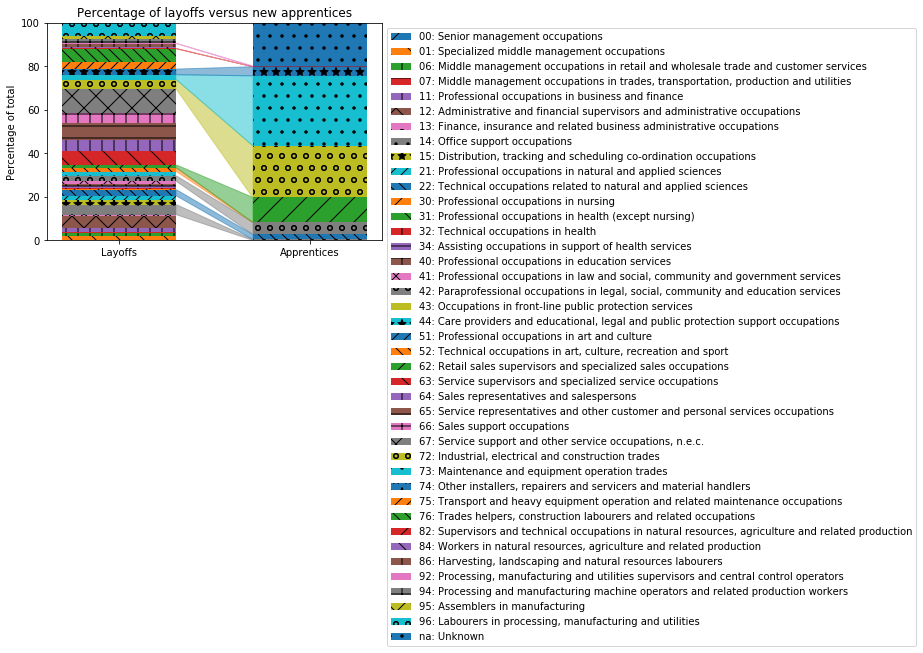

In [53]:
# Plot with hatching to indicate NOC, legend only containing 2 NOC digits
x_loc = np.arange(1)

fig, ax = plt.subplots()
lay_bottom = [0]
app_bottom = [0]
bars_for_legend = []
code_for_legend = []
width = 0.6

pt = 0

for i in range(len(ordered_nocs)):
    noc2 = ordered_nocs[i]
    lay = layoffs_normalized[i]
    app = apps_normalized[i]

            
    bar1 = ax.bar(x_loc, [lay], bottom=lay_bottom, width=width, hatch=patterns[pt])
    color = bar1[0].get_facecolor()
    bar2 = ax.bar(x_loc+1, [app], bottom=app_bottom, width=width, color=color, hatch=patterns[pt])
    lay_bottom = [lay+lay_bottom[0]]
    app_bottom = [app+app_bottom[0]]
    
    noc_title = noc_to_area[noc2] if noc2 in noc_to_area else "Unknown"

    bars_for_legend.append(bar1[0])
    code_for_legend.append(noc2 + ": " + noc_title)
    
    if pt < len(patterns)-1:
        pt += 1
    else: 
        pt = 0
            
    # Path between bars, if both exist for this noc
    if lay != 0 and app != 0:
        b1_tr = (x_loc[0] + width/2, lay_bottom[0])
        b1_br = (x_loc[0] + width/2, lay_bottom[0]-lay)
        b2_tl = (x_loc[0]+1 - width/2, app_bottom[0])
        b2_bl = (x_loc[0]+1 - width/2, app_bottom[0]-app)
                
        path_codes = [mpath.Path.MOVETO, mpath.Path.LINETO, mpath.Path.LINETO, mpath.Path.LINETO, mpath.Path.CLOSEPOLY]
        path_verts = [b1_tr, b2_tl, b2_bl, b1_br, b1_tr]
        path = mpath.Path(path_verts, path_codes)
        patch = mpatches.PathPatch(path, facecolor=color, edgecolor=color, alpha=0.5)
        ax.add_patch(patch)
    
    
ax.set_xticks([0, 1])
ax.set_xticklabels(["Layoffs", "Apprentices"])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
ax.set_ylabel("Percentage of total")
    
plt.legend(tuple(bars_for_legend), tuple(code_for_legend), loc="upper left", bbox_to_anchor=(1,1))
plt.title("Percentage of layoffs versus new apprentices")
plt.show()

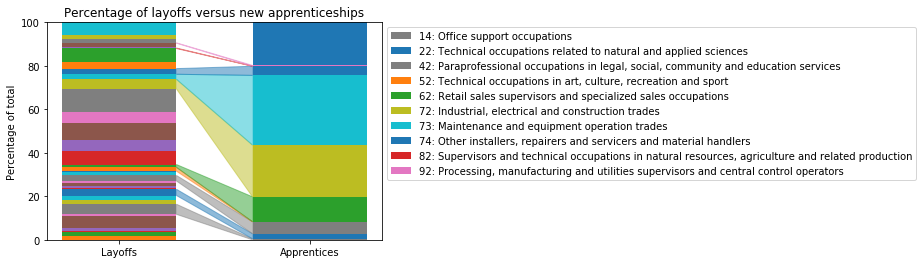

In [56]:
# Plot with NOC names in legend, no hatching

x_loc = np.arange(1)

fig, ax = plt.subplots()
lay_bottom = [0]
app_bottom = [0]
bars_for_legend = []
code_for_legend = []
width = 0.6

for i in range(len(ordered_nocs)):
    noc2 = ordered_nocs[i]
    lay = layoffs_normalized[i]
    app = apps_normalized[i]

            
    bar1 = ax.bar(x_loc, [lay], bottom=lay_bottom, width=width)
    color = bar1[0].get_facecolor()
    bar2 = ax.bar(x_loc+1, [app], bottom=app_bottom, width=width, color=color)
    lay_bottom = [lay+lay_bottom[0]]
    app_bottom = [app+app_bottom[0]]
                
    # Path between bars, if both exist for this noc
    if lay != 0 and app != 0:
        b1_tr = (x_loc[0] + width/2, lay_bottom[0])
        b1_br = (x_loc[0] + width/2, lay_bottom[0]-lay)
        b2_tl = (x_loc[0]+1 - width/2, app_bottom[0])
        b2_bl = (x_loc[0]+1 - width/2, app_bottom[0]-app)
                
        path_codes = [mpath.Path.MOVETO, mpath.Path.LINETO, mpath.Path.LINETO, mpath.Path.LINETO, mpath.Path.CLOSEPOLY]
        path_verts = [b1_tr, b2_tl, b2_bl, b1_br, b1_tr]
        path = mpath.Path(path_verts, path_codes)
        patch = mpatches.PathPatch(path, facecolor=color, edgecolor=color, alpha=0.5)
        ax.add_patch(patch)
        
        # And add to legend
        noc_title = noc_to_area[noc2] if noc2 in noc_to_area else "Unknown"
        bars_for_legend.append(bar1[0])
        code_for_legend.append(noc2 + ": " + noc_title)
    
    
ax.set_xticks([0, 1])
ax.set_xticklabels(["Layoffs", "Apprentices"])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
ax.set_ylabel("Percentage of total")
    
plt.legend(tuple(bars_for_legend), tuple(code_for_legend), loc="upper left", bbox_to_anchor=(1,1))
plt.title("Percentage of layoffs versus new apprenticeships")
plt.show()